In [2]:
import pandas as pd
import numpy as np
from plotnine import *

# Pipeline:

- prepare sample table
- run trimming to remove adapters and primers
- run dada2 to generate ASVs, remove chimeras, and abundance table
- run nextclade to call SNVs and indels


TO-DO:

Turn pipeline into an executable that takes sample table as input

# Set up sample directory
1. download reads into data/raw
2. make read_list.txt (ls \*R1\*.fastq.gz > reads_list.txt)
3. make subdirectories within data/raw for each amplicon
4. make trimmed_reads directories for each amplicon (e.g. data/raw/ntd/trimmed_reads)

# Make sample table (can do this in a spreadsheet or here)

**sample table must have columns:**

- read1 # basename of read file 1 (e.g. "NTD_I_I_INF_101321_1_S58_L001_R2_001.fastq.gz")
- read2 # created off of read1
- amplicon # extracted from read1 (e.g. "NTD")
- sample_id # extracted from read1, following lab convention (e.g. "I_I_INF_101321_1")
- merge_id # same as sample_id, or a replicate sample with a Cq value in qPCR table (if the sample sent for sequencing was not analyzed via qPCR)
- treatment # any upstream non-standard treatment performed on the sample or RNA (e.g. "rRd" for RNA depletion)
- datadir # location of read1 and read2 files

In [229]:
# 10/4/21
# # samples given to Justin were run with RBD primers only and were processed with rRNA depletion ('rRd') or without ('STD')
# # samples run in-house were labeled "RBD"

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_100421'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df[['amplicon','sample_id']] = reads_df.read1.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'inhouse'
reads_df.loc[reads_df.amplicon == 'rRd', 'treatment'] = 'rRd'
reads_df.loc[reads_df.treatment == 'rRd', 'amplicon'] = 'RBD' # rename amplicon, all ribodepleted samples were RBD this round
reads_df.loc[reads_df.amplicon == 'STD', 'treatment'] = 'std'
reads_df.loc[reads_df.amplicon == 'STD', 'amplicon'] = 'RBD' # the non-ribodepleted amplicons from FGL were RBD but got named "STD" for standard treatment
reads_df['datadir'] = datadir

# In this run, the same samples were run with and without ribodepletion. Give these unique names:
reads_df.loc[reads_df.treatment.isin(['std', 'rRd']), 'sample_id'] = reads_df.treatment + "_" + reads_df.sample_id

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [31]:
# 11/5/21
# samples all processed with rRNA depletion at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_110521'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace('Twist_2_23', 'control_Twist_2_23_101521') # to match pattern
reads_df['read_name'] = reads_df.read_name.str.replace('control_PBS', 'control_control_PBS') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'rRd' # all were ribodepleted
reads_df['datadir'] = datadir

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [78]:
# 11/19/21

# samples all processed with rRNA depletion at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_111921'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace('Twistcontrol', 'control_Twist_2_23_110121') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'rRd' # all were ribodepleted
reads_df['datadir'] = datadir

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

In [89]:
# 12/7/21

# samples all processed with rRNA depletion at FGL/GSL

datadir = '/Users/rosekantor/data/wbe_scv/qb3_sgene_120721'
reads_df = pd.read_csv(f'{datadir}/raw/reads_list.txt', names=['read1'])

reads_df = reads_df[~reads_df.read1.str.contains('Undetermined')]
reads_df['read2'] = reads_df.read1.str.replace(r'_R1_', '_R2_')
reads_df['read_name'] = reads_df.read1.str.replace('Twist_control', 'control_Twist_2_23_111521') # to match pattern
reads_df['read_name'] = reads_df.read_name.str.replace('control_PBS', 'control_control_PBS') # to match pattern
reads_df[['amplicon','sample_id']] = reads_df.read_name.str.extract(r'(\w+)_(.+_.+_.+_\d+_\d+)_S\d+_L001_R._001\.fastq\.gz')
reads_df['merge_id'] = reads_df['sample_id'].copy()
reads_df['treatment'] = 'rRd' # all were ribodepleted
reads_df['datadir'] = datadir

# RBD got named RDB in the reads names
reads_df.loc[reads_df.amplicon == 'RDB', 'amplicon'] = 'RBD'

reads_df.to_csv(f'{datadir}/sample_table.csv', index=False)

# Generate commands

In [90]:
reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_120721/sample_table.csv')
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_111921/sample_table.csv')
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_110521/sample_table.csv')
# reads_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_100421/sample_table.csv')

In [95]:
# trim adapters and primers with cutadapt, specific to the primers used

# dict of fwd and rev trimming sequences
trim_seqs = {'RBD':['GTGATGAAGTCAGACAAATCGC...CAGACACTTGAGATTCTTGACAT', 
                    'ATGTCAAGAATCTCAAGTGTCTG...GCGATTTGTCTGACTTCATCAC'],
             'NTD':['CATTCAACTCAGGACTTGTTCTT...TTTCGGCTTTAGAACCATTGG',
                    'CCAATGGTTCTAAAGCCGAAA...AAGAACAAGTCCTGAGTTGAATG'],
             'S1S2':['CAGGCACAGGTGTTCTTACT...CTACCAGTGTCTATGACCAAGAC',
                     'GTCTTGGTCATAGACACTGGTAG...AGTAAGAACACCTGTGCCTG']}

trim_cmd = []
for r in reads_df.itertuples():
    raw_path = f'{r.datadir}/raw'
    amplicon = r.amplicon
    trimmedF = f'{raw_path}/{amplicon.lower()}/trimmed_reads/{r.sample_id}.1.fastq.gz'
    trimmedR = f'{raw_path}/{amplicon.lower()}/trimmed_reads/{r.sample_id}.2.fastq.gz'
    
    cutadapt_cmd = f'cutadapt -a {trim_seqs[amplicon][0]} -A {trim_seqs[amplicon][1]} --discard-untrimmed -o {trimmedF} -p {trimmedR} {raw_path}/{r.read1} {raw_path}/{r.read2} | tee {raw_path}/{r.read_name}_trim.log'
    
    trim_cmd.append(cutadapt_cmd)

reads_df['trim_cmd'] = trim_cmd

# save commands
datadir = reads_df.datadir.values[0]
reads_df.trim_cmd.to_csv(f'{datadir}/read_trimming.sh', index=False, header=False)

In [96]:
# write commands for dada2 pipeline and nextclade

amplicons = ['NTD', 'RBD', 'S1S2']
datadir = reads_df.datadir.values[0]
dada2_pipeline = '/Users/rosekantor/work/sarscov2_sequencing/pipeline_dada2.R'
nextclade = '/Users/rosekantor/work/wbe_sequence_analysis/nextclade'
nextclade_ref = '/Users/rosekantor/work/wbe_sequence_analysis/nextclade_data/sars-cov-2'
dada2_out = f'{datadir}/results/dada2_out'
nextclade_out = f'{datadir}/results/nextclade_out'
dada_merge = '~/work/sarscov2_sequencing/merge_seqtabs.R'

final_out = '~/data/wbe_scv/results_sgene'

# NOTE: trimmed reads from each amplicon need to be in separate folders for dada2 to run on one amplicon at a time

with open(f'{datadir}/analysis_cmds.sh', 'w') as f:
    # option ot update nextclade and ref dataset
    # f.write('cd /Users/rosekantor/work/wbe_sequence_analysis\n')
    # f.write('curl -fsSL "https://github.com/nextstrain/nextclade/releases/latest/download/nextclade-MacOS-arm64" -o "nextclade" && chmod +x nextclade\n')
    # f.write('/Users/rosekantor/work/wbe_sequence_analysis/nextclade dataset get --name "sars-cov-2" --output-dir "nextclade_data/sars-cov-2"\n')

    f.write(f'mkdir {datadir}/results\n')
    f.write(f'mkdir {dada2_out}\n')
    f.write(f'mkdir {nextclade_out}\n')
    for amplicon in amplicons: 
        trimmed_path = f'{datadir}/raw/{amplicon.lower()}/trimmed_reads/'
        dada2_cmd = f'{dada2_pipeline} {amplicon} {trimmed_path} {dada2_out}'
        f.write(dada2_cmd + '\n')
        # nextclade_cmd = f'{nextclade} --in-order --input-fasta {dada2_out}/{amplicon}_dada2_out.fasta --input-dataset {nextclade_ref} --output-csv {nextclade_out}/{amplicon}_nextclade.csv --output-dir {nextclade_out}'
        # f.write(nextclade_cmd + '\n') # run nextclade on combined data instead of here
        
    # merge all seqtabs and run nextclade on them combined
    f.write(dada_merge + '\n')
    for amplicon in amplicons: 
        nextclade_cmd = f'{nextclade} --in-order --input-fasta {final_out}/{amplicon}_combined_dada2_out.fasta --input-dataset {nextclade_ref} --output-csv {final_out}/nextclade_out/{amplicon}_combined_nextclade.csv --output-dir {final_out}/nextclade_out'
        f.write(nextclade_cmd + '\n')
    
f.close()

# Reviewing the effect of rRNA depletion

In [72]:
rRd_comp = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_100421/results/dada2_out/RBD_read_tracking.csv')
rRd_comp[['treatment', 'Sample']] = rRd_comp['Row.names'].str.extract('(\w+)_(.+_.+_.+_.+_.+)')
rRd_comp = rRd_comp.drop(columns='Row.names')
rRd_comp = rRd_comp.melt(id_vars=['Sample', 'treatment'])
rRd_comp.loc[rRd_comp.treatment=='RBD', 'treatment'] = 'in-house'

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


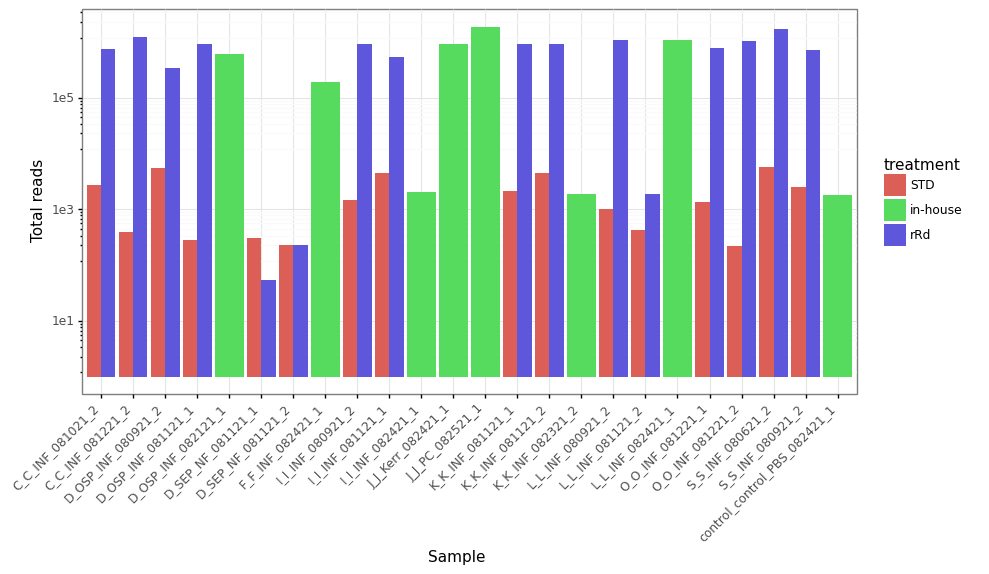

<ggplot: (359187185)>

In [76]:
(ggplot(rRd_comp[(rRd_comp.variable=='input') ], aes(x='Sample', y='value', fill='treatment'))+
#geom_point()+
geom_bar(stat='identity', position='dodge')+
 scale_y_log10()+
 ylab('Total reads')+
#facet_wrap('~treatment')+
theme_bw()+
theme(figure_size=(10, 5), axis_text_x=element_text(angle=45, hjust=1)))